In [2]:
# import packages
import scipy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
# load data from mat file
mat = scipy.io.loadmat("exampleEMGdata180trial_train.mat")

# load test data from mat file
# test = scipy.io.loadmat("exampleEMGdata120trial_test.mat")
test = scipy.io.loadmat("anotherDay.mat")

In [4]:
# get keys of data from mat file
mat.keys()

test.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Fs', 'actualFs', 'dataChTimeTr', 'label_names', 'labels', 'numCh'])

In [5]:
# assign data for plotting and feature extraction to variables
data = mat['dataChTimeTr']
data_dim = mat['dataChTimeTr'].shape
Fs = mat['Fs'][0][0]
num_timesteps = data_dim[1]

# list for assigning label numbers to the conditions they represent
label_rps = ['rock', 'paper', 'scissors']
labels = mat['labels']
label_names = mat['label_names']
numCh = mat['numCh'][0][0]


# make time vector
time_ms = np.linspace(0, Fs*num_timesteps-Fs, num_timesteps)

print(f"data dimensions: {data_dim}")

data dimensions: (4, 1400, 180)


In [6]:
# test data
test_data = test['dataChTimeTr']
test_data_dim = test['dataChTimeTr'].shape
test_Fs = test['Fs'][0][0]
test_num_timesteps = test_data_dim[1]

test_labels = test['labels']
test_label_names = test['label_names']
test_numCh = test['numCh'][0][0]

# make time vector
test_time_ms = np.linspace(0, test_Fs*test_num_timesteps-test_Fs, test_num_timesteps)

In [7]:
test_labels
cond = 3
len([x[0] for x in list(test_labels) if x[0] == cond])

32

In [8]:
# extract signals from specific data channel
def extract_signal(data, labnam_in, lab_in, label_conv, ch_in):
    ch = ch_in
    all_cond_signals = {} # dictionary of signals, key is condition, value is list of signals for that condition from the dataset

    for cond in labnam_in:
            trials = [idx-1 for idx in range(len(lab_in)) if lab_in[idx-1]==cond[0]] # makes list of indices of all trials of a specific condition
            cond_signals = [[v[tr-1] for v in data[ch-1]] for tr in trials] # makes list of signals from each trial of a specificed condition
            all_cond_signals[label_conv[cond[0]-1]] = cond_signals

    return all_cond_signals

(5371.1615059225005-545971.8760711979j)
4593.184933718296
0.04


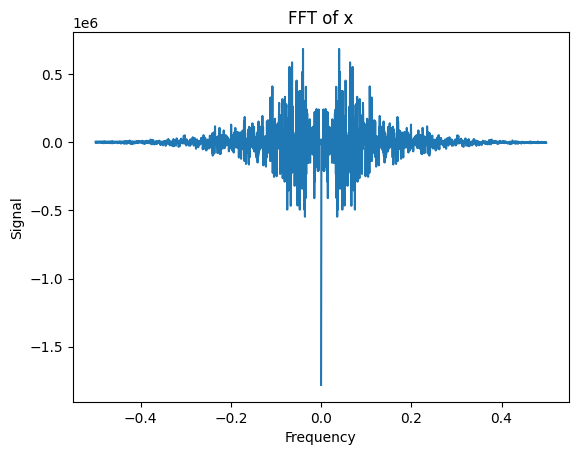

In [9]:
rock_signal = np.array(extract_signal(data, label_names, labels, label_rps, 1)['scissors'][0])
x_f = np.fft.fft(rock_signal)
freqs = np.fft.fftfreq(rock_signal.shape[-1])      # get sample frequencies for which FFT was computed



# plt.plot(freqs, x_f.real, freqs, x_f.imag)
plt.plot(freqs, x_f.real)
plt.xlabel('Frequency')
plt.ylabel('Signal')
plt.title('FFT of x')
# plt.legend(['real', 'imag'])

print(np.average(x_f, weights=freqs))
print(np.sqrt(sum([x*x for x in rock_signal])/num_timesteps))

x_f_abs = [abs(x) for x in x_f.real]
print(freqs[np.where(x_f_abs==max(x_f_abs[1:]))[0]][0])


In [10]:
# feature extraction functions
# used in histogram plotter

# get root mean square from list of signal data
def get_rms(data, num_timesteps):
    return np.sqrt(sum([x*x for x in data])/num_timesteps)

# get waveform length from list of signal data
def get_wl(data, num_timesteps):
    return sum([abs(data[idx+1]-data[idx]) for idx in range(len(data)-1)])/num_timesteps

# get variance from list of signal data
def get_var(data, num_timesteps):
    return np.var(data)

# get integrated EMG from list of signal data
def get_iemg(data, num_timesteps):
    return sum([abs(x) for x in data])

# get mean frequency from list of signal data
def get_mf(data, num_timesteps):
    data = np.array(data)
    fft = [abs(x) for x in np.fft.fft(data).real]
    freqs = [abs(x) for x in np.fft.fftfreq(data.shape[-1])]
    
    return np.average(freqs, weights=fft)

# get peak frequency from list of signal data
def get_pf(data, num_timesteps):
    data = np.array(data)
    fft = [abs(x) for x in np.fft.fft(data).real]
    freqs = np.fft.fftfreq(data.shape[-1])
    return abs(freqs[np.where(fft==max(fft[1:]))[0]][0])

In [11]:
# function for extracting features of each condition from a dictionary of (condition, list of signals) pairs
def extract_feature_condition(data, labnam_in, lab_in, label_conv, ch_in, num_timesteps, func):
    all_cond_signal = extract_signal(data, labnam_in, lab_in, label_conv, ch_in) # dictionary of signals, key is condition, value is list of signals for that condition from the dataset
    cond_features = {cond: [func(signal, num_timesteps) for signal in all_cond_signal[cond]] for cond in all_cond_signal} # dictionary of features, key is condition, value is list of features for that condition
    return cond_features

In [12]:
# histogram plotter function
def make_histogram(data, labnam_in, lab_in, label_conv, num_timesteps, func, ch_in, bins_in, domain):
    ch = ch_in
    bins = bins_in

    features = extract_feature_condition(data, labnam_in, lab_in, label_conv, ch, num_timesteps, func)

    # plot features on histogram
    [plt.hist(features[cond], bins, alpha=0.5) for cond in features]

    # add legend, axis, and title to histogram
    plt.legend(features.keys())
    if domain == "time":
        plt.xlabel('Adjusted Voltage')
    elif domain == "frequency":
        plt.xlabel('Frequency')
    plt.ylabel('Count')
    plt.title(f'{func.__name__[4:].upper()} Values for RPS Conditions From Channel {ch}')

In [13]:
# # select channel and trial
# ch = 3
# tr = 1
# one_signal = [v[tr-1] for v in mat['dataChTimeTr'][ch-1]]

# # plot signal from specific channel of specific trial
# plt.plot(time_ms, one_signal)

# # calculate RMS
# rms = get_rms(one_signal, num_timesteps)
# print(one_signal)
# print(f"rms = {rms}")

# # actual condition
# ac_condition = label_rps[labels[tr-1][0]-1]
# print(ac_condition)

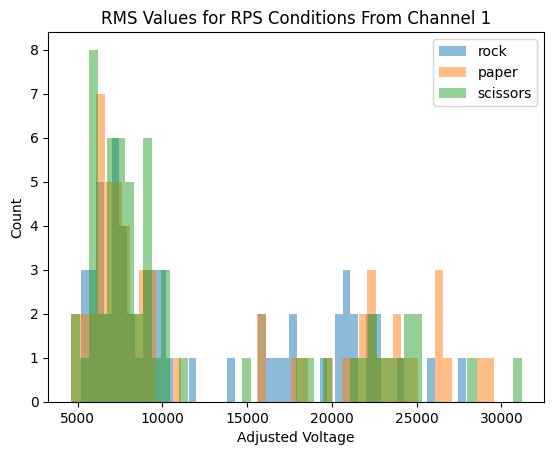

In [14]:
# RMSs histogram
ch = 1
bins = 50

make_histogram(data, label_names, labels, label_rps, num_timesteps, get_rms, ch, bins, 'time')


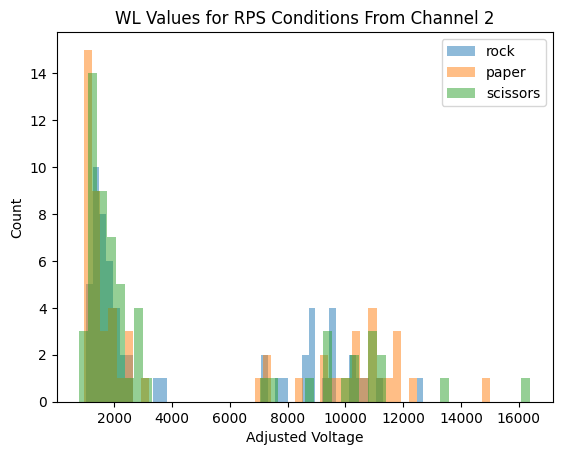

In [15]:
# WLs histogram
ch = 2
bins = 50

make_histogram(data, label_names, labels, label_rps, num_timesteps, get_wl, ch, bins, 'time')

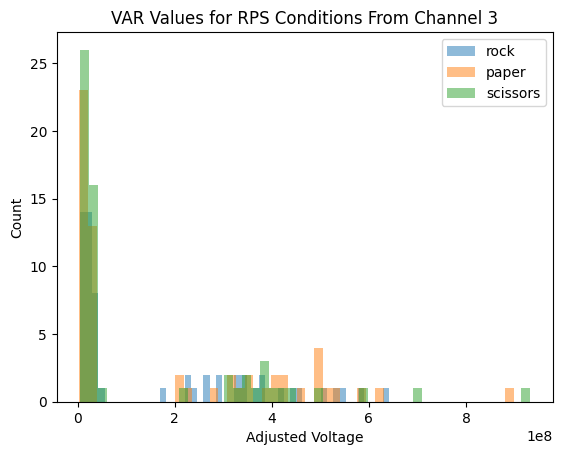

In [16]:
# VARs histogram
ch = 3
bins = 50

make_histogram(data, label_names, labels, label_rps, num_timesteps, get_var, ch, bins, 'time')

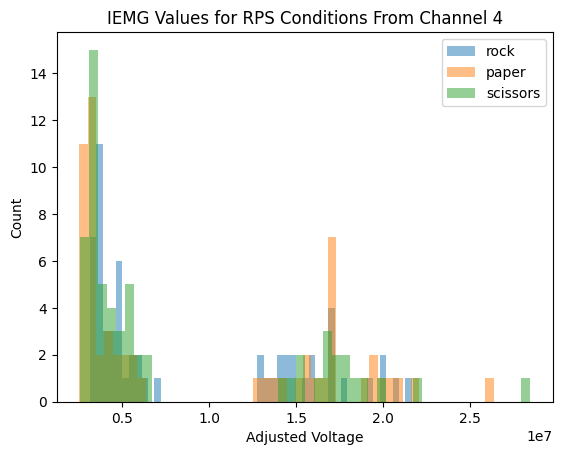

In [17]:
# IEMGs histogram
ch = 4
bins = 50

make_histogram(data, label_names, labels, label_rps, num_timesteps, get_iemg, ch, bins, 'time')

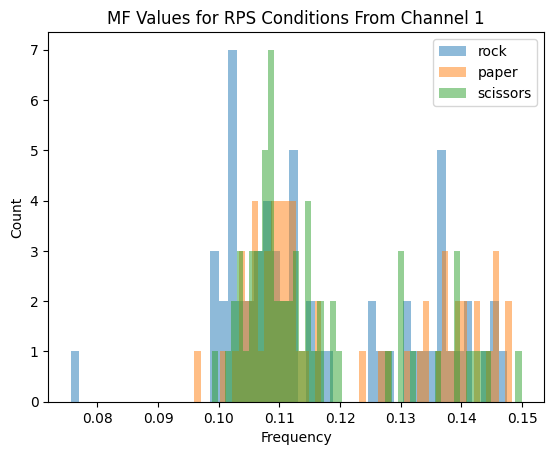

In [18]:
# MFs histogram
ch = 1
bins = 50

make_histogram(data, label_names, labels, label_rps, num_timesteps, get_mf, ch, bins, "frequency")

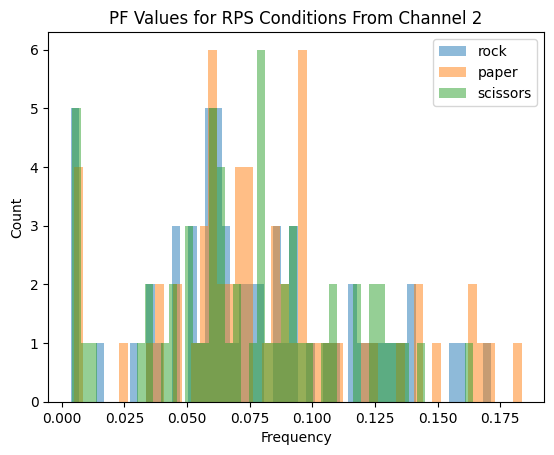

In [19]:
# PFs histogram
ch = 2
bins = 50

make_histogram(data, label_names, labels, label_rps, num_timesteps, get_pf, ch, bins, "frequency")

In [20]:
def prep_data_feature(data, labnam_in, lab_in, label_conv, num_timesteps, func):
    return {f'{func.__name__[4:].upper()} ch {ch_num}': extract_feature_condition(data, labnam_in, lab_in, label_conv, ch_num, num_timesteps, func) for ch_num in range(numCh+1)[1:]}

In [21]:
def prep_data_feature(data, labnam_in, lab_in, label_conv, num_timesteps, func):
    values = {f'{func.__name__[4:].upper()} ch {ch_num}': extract_feature_condition(data, labnam_in, lab_in, label_conv, ch_num, num_timesteps, func) for ch_num in range(numCh+1)[1:]}
    columns = [[val for sublist in [values[ch][cond] for cond in values[ch]] for val in sublist] for ch in values]

    return values.keys(), columns

In [22]:
# export training data features

rms_headers, rms_columns = prep_data_feature(data, label_names, labels, label_rps, num_timesteps, get_rms)
wl_headers, wl_columns = prep_data_feature(data, label_names, labels, label_rps, num_timesteps, get_wl)
var_headers, var_columns = prep_data_feature(data, label_names, labels, label_rps, num_timesteps, get_var)
iemg_headers, iemg_columns = prep_data_feature(data, label_names, labels, label_rps, num_timesteps, get_iemg)
mf_headers, mf_columns = prep_data_feature(data, label_names, labels, label_rps, num_timesteps, get_mf)
pf_headers, pf_columns = prep_data_feature(data, label_names, labels, label_rps, num_timesteps, get_pf)

labels_column = [*list(np.zeros(60, dtype=int)), *list(np.ones(60, dtype=int)), *list(2*np.ones(60, dtype=int))]

headers = [*list(rms_headers), *list(wl_headers), *list(var_headers), *list(iemg_headers), *list(mf_headers), *list(pf_headers), *['labels']]

feature_data = pd.DataFrame(list(zip(rms_columns[0], rms_columns[1], rms_columns[2], rms_columns[3], 
                                     wl_columns[0], wl_columns[1], wl_columns[2], wl_columns[3],
                                     var_columns[0], var_columns[1], var_columns[2], var_columns[3],
                                     iemg_columns[0], iemg_columns[1], iemg_columns[2], iemg_columns[3],
                                     mf_columns[0], mf_columns[1], mf_columns[2], mf_columns[3],
                                     pf_columns[0], pf_columns[1], pf_columns[2], pf_columns[3],
                                     labels_column
                                     )), 
                            columns=headers)

feature_data.to_csv('features.csv', index=False)




In [23]:
# export test data features

test_rms_headers, test_rms_columns = prep_data_feature(test_data, test_label_names, test_labels, label_rps, test_num_timesteps, get_rms)
test_wl_headers, test_wl_columns = prep_data_feature(test_data, test_label_names, test_labels, label_rps, test_num_timesteps, get_wl)
test_var_headers, test_var_columns = prep_data_feature(test_data, test_label_names, test_labels, label_rps, test_num_timesteps, get_var)
test_iemg_headers, test_iemg_columns = prep_data_feature(test_data, test_label_names, test_labels, label_rps, test_num_timesteps, get_iemg)
test_mf_headers, test_mf_columns = prep_data_feature(test_data, test_label_names, test_labels, label_rps, test_num_timesteps, get_mf)
test_pf_headers, test_pf_columns = prep_data_feature(test_data, test_label_names, test_labels, label_rps, test_num_timesteps, get_pf)

test_labels_column = [*list(np.zeros(40, dtype=int)), *list(np.ones(40, dtype=int)), *list(2*np.ones(40, dtype=int))]

test_headers = [*list(test_rms_headers), *list(test_wl_headers), *list(test_var_headers), *list(test_iemg_headers), *list(test_mf_headers), *list(test_pf_headers), *['labels']]

test_feature_data = pd.DataFrame(list(zip(test_rms_columns[0], test_rms_columns[1], test_rms_columns[2], test_rms_columns[3], 
                                     test_wl_columns[0], test_wl_columns[1], test_wl_columns[2], test_wl_columns[3],
                                     test_var_columns[0], test_var_columns[1], test_var_columns[2], test_var_columns[3],
                                     test_iemg_columns[0], test_iemg_columns[1], test_iemg_columns[2], test_iemg_columns[3],
                                     test_mf_columns[0], test_mf_columns[1], test_mf_columns[2], test_mf_columns[3],
                                     test_pf_columns[0], test_pf_columns[1], test_pf_columns[2], test_pf_columns[3],
                                     test_labels_column
                                     )), 
                            columns=test_headers)

test_feature_data.to_csv('test_features.csv', index=False)

In [24]:
def make_feature_table(file_name, num_rocks, num_papers, num_scissors):

    dataset = scipy.io.loadmat(file_name)

    # test data
    feature_data = dataset['dataChTimeTr']
    feature_data_dim = dataset['dataChTimeTr'].shape
    feature_num_timesteps = feature_data_dim[1]

    feature_labels = dataset['labels']
    feature_label_names = dataset['label_names']

    conversion = ['rock', 'paper', 'scissors']

    rms_headers, rms_columns = prep_data_feature(feature_data, feature_label_names, feature_labels, conversion, feature_num_timesteps, get_rms)
    wl_headers, wl_columns = prep_data_feature(feature_data, feature_label_names, feature_labels, conversion, feature_num_timesteps, get_wl)
    var_headers, var_columns = prep_data_feature(feature_data, feature_label_names, feature_labels, conversion, feature_num_timesteps, get_var)
    iemg_headers, iemg_columns = prep_data_feature(feature_data, feature_label_names, feature_labels, conversion, feature_num_timesteps, get_iemg)
    mf_headers, mf_columns = prep_data_feature(feature_data, feature_label_names, feature_labels, conversion, feature_num_timesteps, get_mf)
    pf_headers, pf_columns = prep_data_feature(feature_data, feature_label_names, feature_labels, conversion, feature_num_timesteps, get_pf)

    labels_column = [*list(np.zeros(num_rocks, dtype=int)), *list(np.ones(num_papers, dtype=int)), *list(2*np.ones(num_scissors, dtype=int))]

    headers = [*list(rms_headers), *list(wl_headers), *list(var_headers), *list(iemg_headers), *list(mf_headers), *list(pf_headers), *['labels']]

    feature_data = pd.DataFrame(list(zip(rms_columns[0], rms_columns[1], rms_columns[2], rms_columns[3], 
                                        wl_columns[0], wl_columns[1], wl_columns[2], wl_columns[3],
                                        var_columns[0], var_columns[1], var_columns[2], var_columns[3],
                                        iemg_columns[0], iemg_columns[1], iemg_columns[2], iemg_columns[3],
                                        mf_columns[0], mf_columns[1], mf_columns[2], mf_columns[3],
                                        pf_columns[0], pf_columns[1], pf_columns[2], pf_columns[3],
                                        labels_column
                                        )), 
                                columns=headers)

    feature_data.to_csv('feature_table.csv', index=False)

In [25]:
make_feature_table('anotherDay.mat', 30, 31, 32)

In [27]:
rms_headers

dict_keys(['RMS ch 1', 'RMS ch 2', 'RMS ch 3', 'RMS ch 4'])